# Text classification with 1-D Convolutional Neural Networks

In this notebook we are going to use the [GloVe](http://nlp.stanford.edu/projects/glove/) pre-trained embeddings to train a text classifier on the [20 Newsgroup dataset](http://qwone.com/~jason/20Newsgroups/) by using convolutional neural networks. [This project](https://github.com/jarfo/dlsl/blob/master/news20/pretrained_word_embeddings.py) is part of the UPC deep learning for speech and language (dlsl) semminar.


In [32]:
from __future__ import print_function
import os
import numpy as np
from utils import plot_curves
np.random.seed(1337)

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
import timeit
import sys


In [8]:
BASE_DIR = './'
GLOVE_DIR = BASE_DIR + '../../data/glove/'
TRAIN_TEXT_DATA_DIR = BASE_DIR + '../../data/20news/20news-bydate-train/'
TEST_TEXT_DATA_DIR = BASE_DIR + '../../data/20news/20news-bydate-test/'
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100


In [9]:
# utility to read the pre-trained glove vectors
def read_glove_vectors(filename):
    embeddings_index = {}
    f = open(filename)
    coefs = None
    for i, line in enumerate(f):
        values = line.split()
        word = values[0]
        if coefs is None:
            coefs = [[0] * len(values[1:])]
        coefs.append(values[1:])
        embeddings_index[word] = i + 1
    f.close()
    coefsm = np.asarray(coefs, dtype='float32')
    return coefsm, embeddings_index

In [10]:
# Converts a list of texts to a matrix of word indices
def test_to_sequence(texts, index, max_sequence_length):
    texts = map(text_to_word_sequence, texts)
    matrix = np.array(pad_sequences([[index[word] for word in text if word in index] for text in texts], max_sequence_length))
    return matrix

In [11]:
# first, build index mapping words to rows the embeddings matrix
print('Reading word vectors.')
embedding_matrix, embeddings_index = read_glove_vectors(os.path.join(GLOVE_DIR, 'glove.6B.%dd.txt' % EMBEDDING_DIM))
print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

def prepare_texts(text_data_dir, labels_index = {}):
    texts = []  # list of text samples
    labels = []  # list of label ids
    for name in sorted(os.listdir(text_data_dir)):
        path = os.path.join(text_data_dir, name)
        if os.path.isdir(path):
            label_id = labels_index.get(name)
            if label_id is None:
                label_id = len(labels_index)
                labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    if sys.version_info < (3,):
                        f = open(fpath)
                    else:
                        f = open(fpath, encoding='latin-1')
                    texts.append(f.read())
                    f.close()
                    labels.append(label_id)

    return texts, labels, labels_index

train_texts, train_labels, labels_index = prepare_texts(TRAIN_TEXT_DATA_DIR)
print('Found %s training texts.' % len(train_texts))
test_texts, test_labels, labels_index = prepare_texts(TEST_TEXT_DATA_DIR, labels_index)
print('Found %s test texts.' % len(test_texts))

Reading word vectors.
Found 400000 word vectors.
Processing text dataset
Found 11314 training texts.
Found 7532 test texts.


In [12]:
# finally, vectorize the text samples into a 2D integer tensor
X_train = test_to_sequence(train_texts, embeddings_index, MAX_SEQUENCE_LENGTH)
X_val = test_to_sequence(test_texts, embeddings_index, MAX_SEQUENCE_LENGTH)

y_train = np.array(train_labels, dtype='int32')
y_val = np.array(test_labels, dtype='int32')

**Exercise:** Define a convolutional architecture (based on 1-D convolutional layers + maxpoolings 1D) to build a classifier that gets GloVe Embeddings injected and has to classify the input context among the possible 20 classes defined in 20news. Advice: Check out the convolutional structures of Keras in https://keras.io/layers/convolutional/ .

In [33]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Building model...')
beg_t = timeit.default_timer()
# TODO: build the conv1D architecture to perform classification on top of the Embeddings input
# input is tensor embedding_layer

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

# TODO: compile the model and request the Accuracy metric to be extracted during training
model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
end_t = timeit.default_timer()
print('Elapsed time to build the model {} s'.format(end_t - beg_t))

Building model...
Elapsed time to build the model 0.645108938217 s


In [34]:
# Let's check the summary of the built model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1000, 100)     40000100    input_6[0][0]                    
____________________________________________________________________________________________________
convolution1d_16 (Convolution1D) (None, 996, 128)      64128       embedding_7[0][0]                
____________________________________________________________________________________________________
maxpooling1d_16 (MaxPooling1D)   (None, 199, 128)      0           convolution1d_16[0][0]           
___________________________________________________________________________________________

**Exercise:** Make a function `num_c1d_parms(num_inputs, num_kernels, kernel_width)` that computes the number of parameters to be adjusted within a C1D layer.

In [37]:
# TODO: make the num_c1d_params(num_inputs, num_kernels, kernel_width) function and test it with some of your built layers
def num_c1d_params(num_inputs, num_kernels, kernel_width):
    return (num_inputs * num_kernels * kernel_width + num_kernels)

print(num_c1d_params(100, 128, 5))

64128


Train on 11314 samples, validate on 7532 samples
Epoch 1/20
8s - loss: 2.8982 - acc: 0.0720 - val_loss: 2.7502 - val_acc: 0.1117
Epoch 2/20
6s - loss: 2.6124 - acc: 0.1498 - val_loss: 2.3822 - val_acc: 0.1666
Epoch 3/20
6s - loss: 2.1561 - acc: 0.2279 - val_loss: 1.9577 - val_acc: 0.3125
Epoch 4/20
6s - loss: 1.7935 - acc: 0.3375 - val_loss: 1.7709 - val_acc: 0.3611
Epoch 5/20
6s - loss: 1.5216 - acc: 0.4331 - val_loss: 1.4847 - val_acc: 0.4689
Epoch 6/20
6s - loss: 1.2964 - acc: 0.5140 - val_loss: 1.4889 - val_acc: 0.4907
Epoch 7/20
6s - loss: 1.1349 - acc: 0.5871 - val_loss: 1.2433 - val_acc: 0.5761
Epoch 8/20
6s - loss: 0.9704 - acc: 0.6482 - val_loss: 1.1694 - val_acc: 0.6057
Epoch 9/20
6s - loss: 0.8289 - acc: 0.7021 - val_loss: 1.1413 - val_acc: 0.6228
Epoch 10/20
6s - loss: 0.7171 - acc: 0.7462 - val_loss: 1.1496 - val_acc: 0.6280
Epoch 11/20
6s - loss: 0.6226 - acc: 0.7770 - val_loss: 1.1057 - val_acc: 0.6510
Epoch 12/20
6s - loss: 0.5562 - acc: 0.7994 - val_loss: 1.1174 - val_

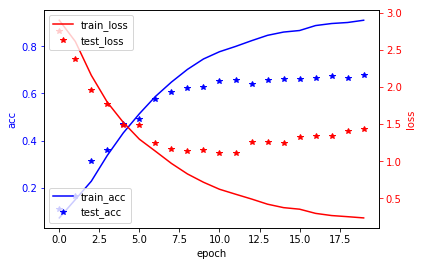

In [27]:
# happy learning!
his = model.fit(X_train, y_train[..., np.newaxis],
                validation_data=(X_val, y_val[..., np.newaxis]),
                nb_epoch=20, batch_size=200, verbose=2)

plot_curves(his, 20)